# ------------- Customer Churn Prediction ----------------


In [29]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

## Loading Dataset


In [30]:
# load dataset
data = pd.read_csv('Telco_Customer_Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [31]:
data.shape

(7043, 21)

In [32]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Data Preprocessing

In [33]:
# drop customerID column as it is not useful for prediction
data.drop('customerID', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [34]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [35]:
# check duplicates 
data.duplicated().sum()

np.int64(22)

In [36]:
# remove duplicates
data.drop_duplicates(inplace=True)
data.duplicated().sum()

np.int64(0)

In [37]:
# convert TotalCharges to numeric, coerce errors to NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].isnull().sum()

np.int64(11)

In [38]:
# fill missing TotalCharges with median
import warnings
warnings.filterwarnings('ignore')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)
data['TotalCharges'].isnull().sum()


np.int64(0)

## EDA (Exploratory Data Analysis)

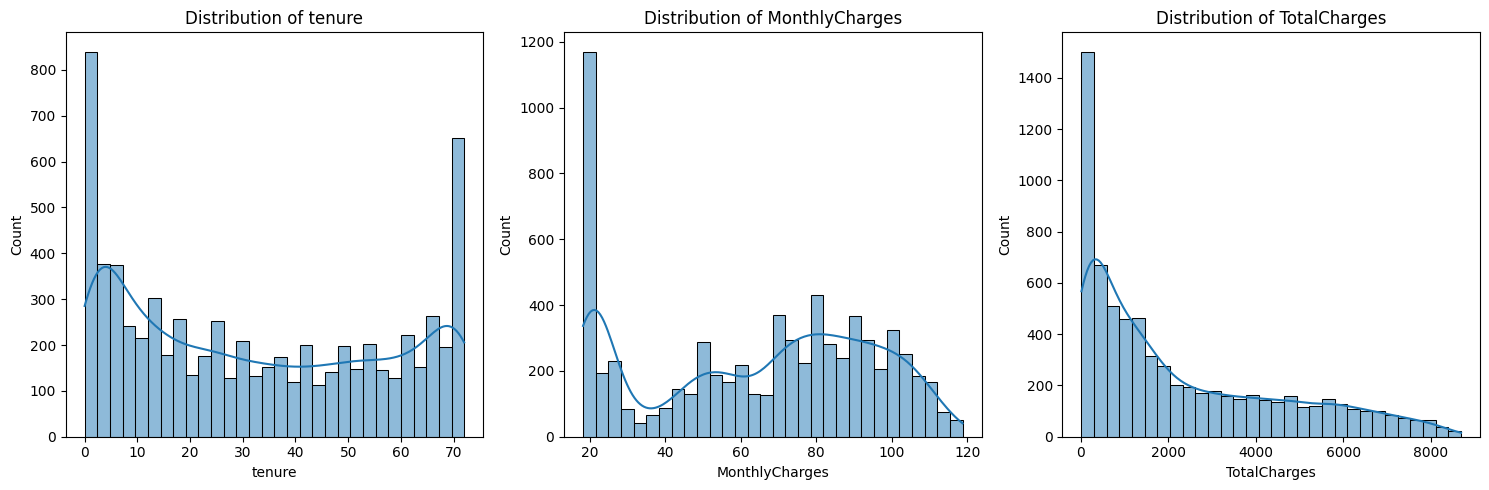

In [39]:
# univariate analysis of numerical features
# creating subplots for numerical features
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


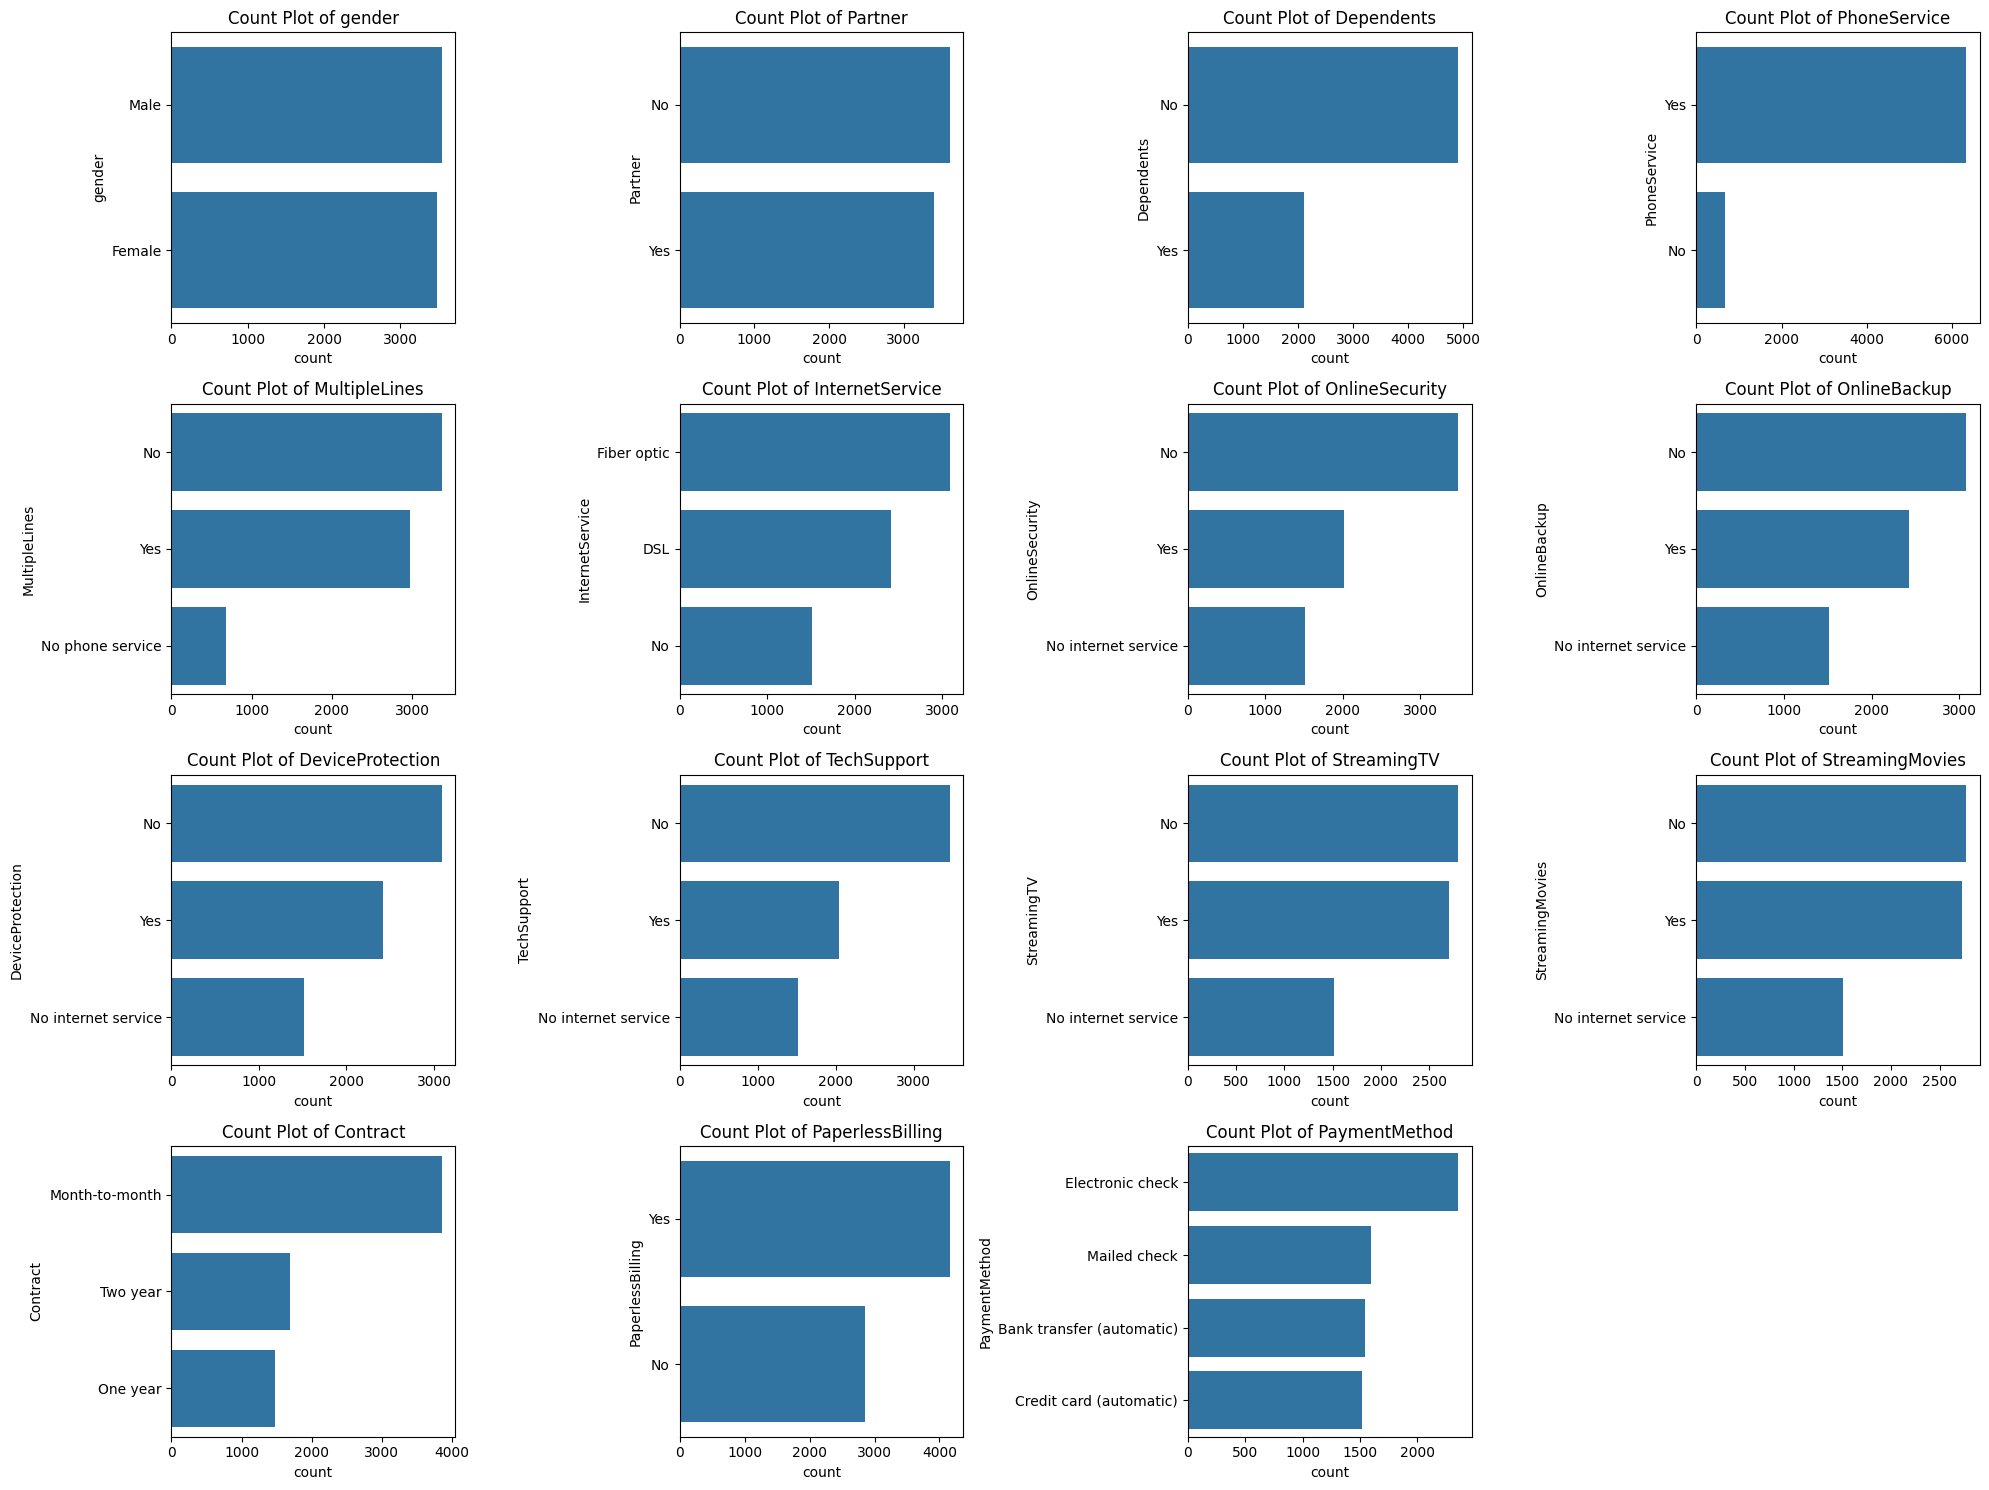

In [40]:
# count plots for categorical features
# creating subplots for categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Churn')  # exclude target variable
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i)
    sns.countplot(y=data[feature], order=data[feature].value_counts().index)
    plt.title(f'Count Plot of {feature}')
plt.tight_layout()
plt.show()

## Feature Engineering 


In [41]:
# feature engineering
# separate numerical and categorical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('Churn')  # exclude target variable
# encode categorical features using OneHotEncoder
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)
# scale numerical features
scaler = StandardScaler()
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])
# encode target variable
data_encoded['Churn'] = data_encoded['Churn'].map({'Yes': 1, 'No': 0})
data_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-0.440508,-1.282728,-1.164135,-0.997334,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,-0.440508,0.062387,-0.262811,-0.176352,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,-0.440508,-1.241967,-0.365914,-0.962766,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,-0.440508,0.510759,-0.750058,-0.197874,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,-0.440508,-1.241967,0.194503,-0.943562,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


## Train-Test Split

In [42]:
# split data into features and target variable
X = data_encoded.drop('Churn', axis=1)
y = data_encoded['Churn']
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.52      0.58       372

    accuracy                           0.80      1405
   macro avg       0.75      0.71      0.73      1405
weighted avg       0.79      0.80      0.79      1405

Logistic Regression Accuracy: 0.8021352313167259
Logistic Regression ROC-AUC: 0.8403244022525477
Recall score: 0.521505376344086


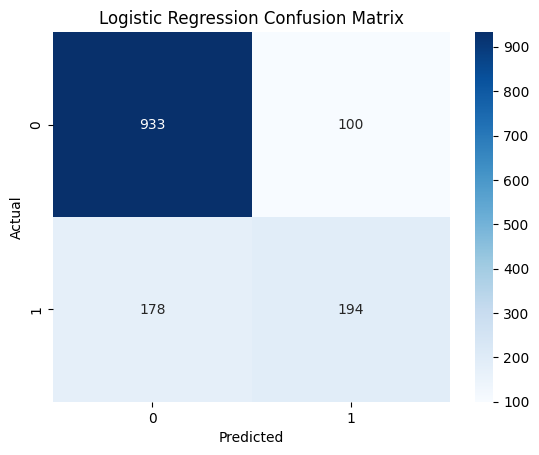

In [43]:
# apply logistic regression
from sklearn.metrics import recall_score

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
# evaluate logistic regression
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg)) 
print("Logistic Regression ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))
print("Recall score:", recall_score(y_test, y_pred_log_reg))
# confusion matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Decision Tree

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1033
           1       0.48      0.49      0.48       372

    accuracy                           0.72      1405
   macro avg       0.65      0.65      0.65      1405
weighted avg       0.72      0.72      0.72      1405

Decision Tree Accuracy: 0.7217081850533807
Decision Tree ROC-AUC: 0.6490296037223245
Recall score: 0.49193548387096775


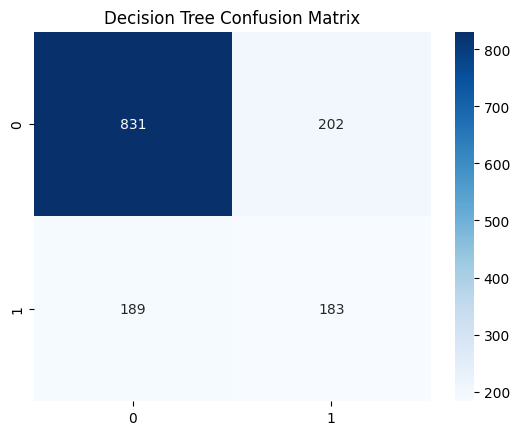

In [44]:
# apply decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
# evaluate model
print(classification_report(y_test, y_pred_dt))
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt)) 
print("Decision Tree ROC-AUC:", roc_auc_score(y_test, dt_clf.predict_proba(X_test)[:, 1]))
print("Recall score:", recall_score(y_test, y_pred_dt))
# confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

## Random Forest

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1033
           1       0.61      0.44      0.51       372

    accuracy                           0.78      1405
   macro avg       0.71      0.67      0.68      1405
weighted avg       0.76      0.78      0.76      1405

Random Forest Accuracy: 0.7772241992882563
Random Forest ROC-AUC: 0.8185418813561085
Recall score: 0.4435483870967742


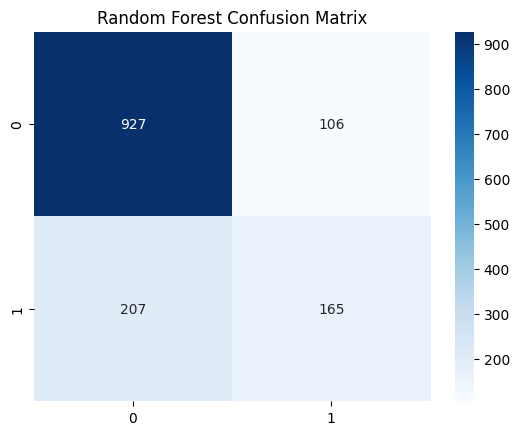

In [45]:
# apply Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
# evaluate model
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1]))
print("Recall score:", recall_score(y_test, y_pred_rf))
# confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

## XGBoost

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1033
           1       0.58      0.47      0.52       372

    accuracy                           0.77      1405
   macro avg       0.70      0.68      0.69      1405
weighted avg       0.76      0.77      0.76      1405

XGBoost Accuracy: 0.7715302491103203
XGBoost ROC-AUC: 0.8194045425683624
Recall score: 0.4731182795698925


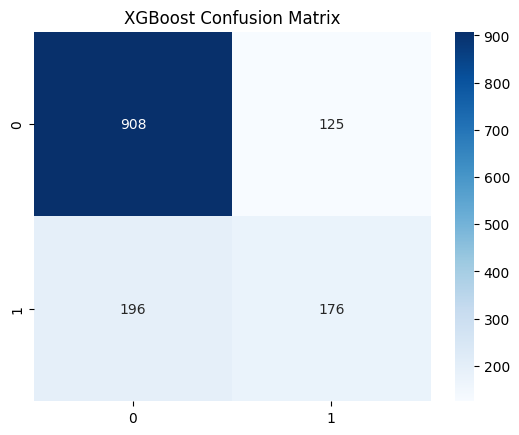

In [46]:
# apply xgboost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
# evaluate model
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))
print("Recall score:", recall_score(y_test, y_pred_xgb))
# confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()

## LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1485, number of negative: 4131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5616, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264423 -> initscore=-1.023105
[LightGBM] [Info] Start training from score -1.023105
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       372

    accuracy                           0.79      1405
   macro avg       0.74      0.70      0.71      1405
weighted avg       0.78      0.79      0.78      1405

LightGBM Accuracy: 0.79288256227758
Lig

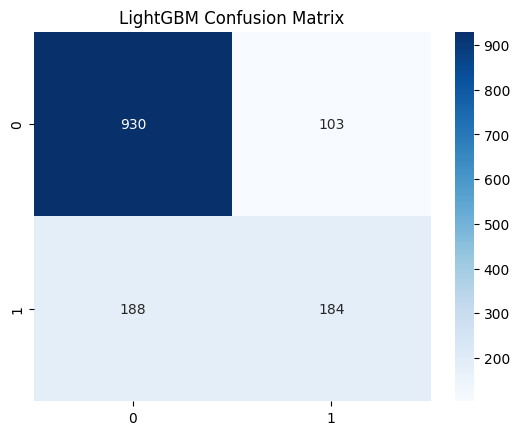

In [47]:
# apply lightgbm classifier
from lightgbm import LGBMClassifier
# import warnings
import warnings
warnings.filterwarnings("ignore")
lgbm_clf = LGBMClassifier(random_state=42)
lgbm_clf.fit(X_train, y_train)  
y_pred_lgbm = lgbm_clf.predict(X_test)
# evaluate model
print(classification_report(y_test, y_pred_lgbm))
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("LightGBM ROC-AUC:", roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1]))
print("Recall score:", recall_score(y_test, y_pred_lgbm))
# confusion matrix
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Blues')
plt.title('LightGBM Confusion Matrix')
plt.show()

## Compare All Models

In [52]:
# compare all models and pick the best one based on recall score
models = {
    'Logistic Regression': log_reg,
    'Decision Tree': dt_clf,   
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
    'LightGBM': lgbm_clf
}
result = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy_score_val = accuracy_score(y_test, y_pred)
    roc_auc_score_val = roc_auc_score(y_test, y_pred)
    recall_score_val = recall_score(y_test, y_pred)
    result[model] = {
        'Accuracy': accuracy_score_val,
        'ROC-AUC': roc_auc_score_val,
        'Recall': recall_score_val
    }
result_df = pd.DataFrame(result).T
result_df.sort_values(by='Recall', ascending=False, inplace=True)
print(result_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1485, number of negative: 4131
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 639
[LightGBM] [Info] Number of data points in the train set: 5616, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.264423 -> initscore=-1.023105
[LightGBM] [Info] Start training from score -1.023105
                                                    Accuracy   ROC-AUC  \
LogisticRegression()                                0.802135  0.712350   
LGBMClassifier(random_state=42)                     0.792883  0.697457   
DecisionTreeClassifier(random_state=42)             0.721708  0.648194   
XGBClassifier(base_score=None, booster=None, ca...  0.771530  0.676056

---
## Using Deep Learning Model (ANN)

In [53]:
# apply deep learning model using keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7084 - loss: 0.5604 - val_accuracy: 0.7918 - val_loss: 0.4488
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7834 - loss: 0.4661 - val_accuracy: 0.7972 - val_loss: 0.4350
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7798 - loss: 0.4562 - val_accuracy: 0.8034 - val_loss: 0.4419
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7876 - loss: 0.4490 - val_accuracy: 0.8016 - val_loss: 0.4364
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7925 - loss: 0.4388 - val_accuracy: 0.7936 - val_loss: 0.4368
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7896 - loss: 0.4383 - val_accuracy: 0.7980 - val_loss: 0.4357
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7956 - loss: 0.4354 - val_accuracy: 0.8007 - val_loss: 0.4389
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7963 - loss: 0.4358 - val_accu

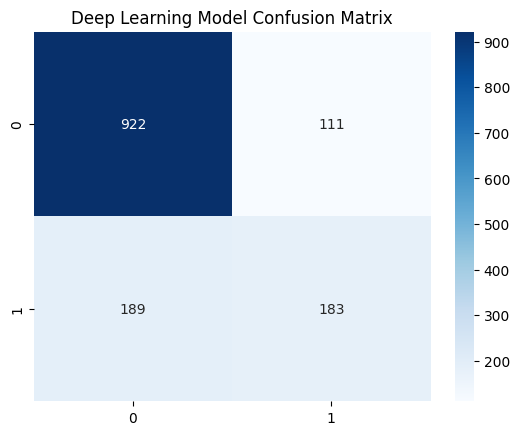

In [55]:
# build the model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
# evaluate the model
y_pred_dl = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_dl))
print("Deep Learning Model Accuracy:", accuracy_score(y_test, y_pred_dl))
print("Deep Learning Model ROC-AUC:", roc_auc_score(y_test, model.predict(X_test)))
print("Recall score:", recall_score(y_test, y_pred_dl))
# confusion matrix
conf_matrix_dl = confusion_matrix(y_test, y_pred_dl)
sns.heatmap(conf_matrix_dl, annot=True, fmt='d', cmap='Blues')
plt.title('Deep Learning Model Confusion Matrix')
plt.show()